# Training 1/3 resolution models (318px)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import rioxarray
import rasterio
import re
import matplotlib.patches as patches
from tqdm import tqdm

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.train_test_val_splitting import *
from levee_hunter.modeling.train import train_model
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.modeling.metrics import get_pred_mask, plot_skeletons, custom_metrics, standard_metrics
from levee_hunter.plotting import plot_training_validation_loss
from levee_hunter.plotting import infer_and_visualize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp


/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

### Creating Dataset

In [2]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/13_384/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/13_384/masks',
    transform=None,
    weighted=True,
    )

# Validation set split
dataset, val_dataset = validation_split(dataset=dataset, val_percentage=0.1, seed=42)
print("Validation dataset: ", len(val_dataset))
val_dataset.weighted = False

# Test set split
train_dataset, test_dataset = train_test_split_dataset(dataset=dataset, test_size=0.1)
print("Test dataset: ", len(test_dataset))
test_dataset.weighted = False

Validation dataset:  141
Test dataset:  118


### Create Data Loaders

In [3]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

### Training Model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

In [6]:
# Define loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=50,
    save_model='best',
    save_model_path="../models/Unet-13_384.pth",
)

beginning training on device: cuda
Epoch: 1/50 Train Loss: 0.293487 Val Loss: 0.223638
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 2/50 Train Loss: 0.170432 Val Loss: 0.141227
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 3/50 Train Loss: 0.132972 Val Loss: 0.113879
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 4/50 Train Loss: 0.111277 Val Loss: 0.096658
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 5/50 Train Loss: 0.098027 Val Loss: 0.083798
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 6/50 Train Loss: 0.085675 Val Loss: 0.073276
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 7/50 Train Loss: 0.080356 Val Loss: 0.067202
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 8/50 Train Loss: 0.073365 Val Loss: 0.063743
Model successfully saved to: ../models/Unet-13_384.pth
Epoch: 9/50 Train Loss: 0.067257 Val Loss: 0.057516
Model successfully saved to: ../models/Unet-13_384.pth
Ep

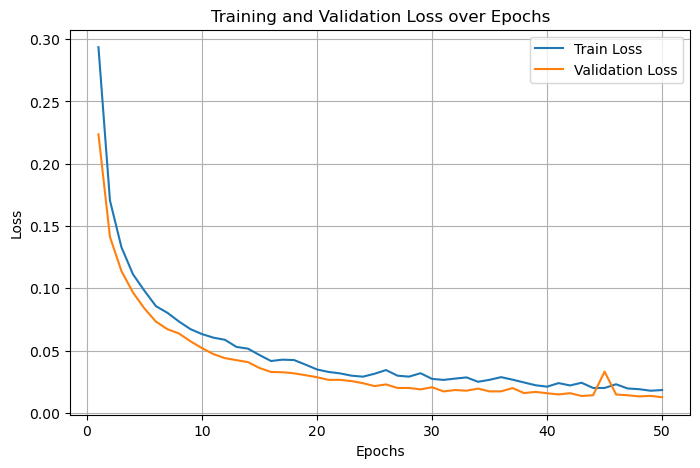

In [7]:
plot_training_validation_loss(train_loss[:], val_loss[:])

### Validating Model

In [8]:
# load saved model
model.load_state_dict(torch.load("../models/Unet-13_384.pth"))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
all_preds, all_targets = get_preds_targets(model, test_loader, device=device)
standard_metrics(targets=all_targets, predictions=all_preds, threshold=0.5)

----------------------Standard Metrics----------------------
IoU Score:         0.0225
F1 Score (Dice):   0.0440
Accuracy:          0.9974
Recall:            0.3272
------------------------------------------------------------


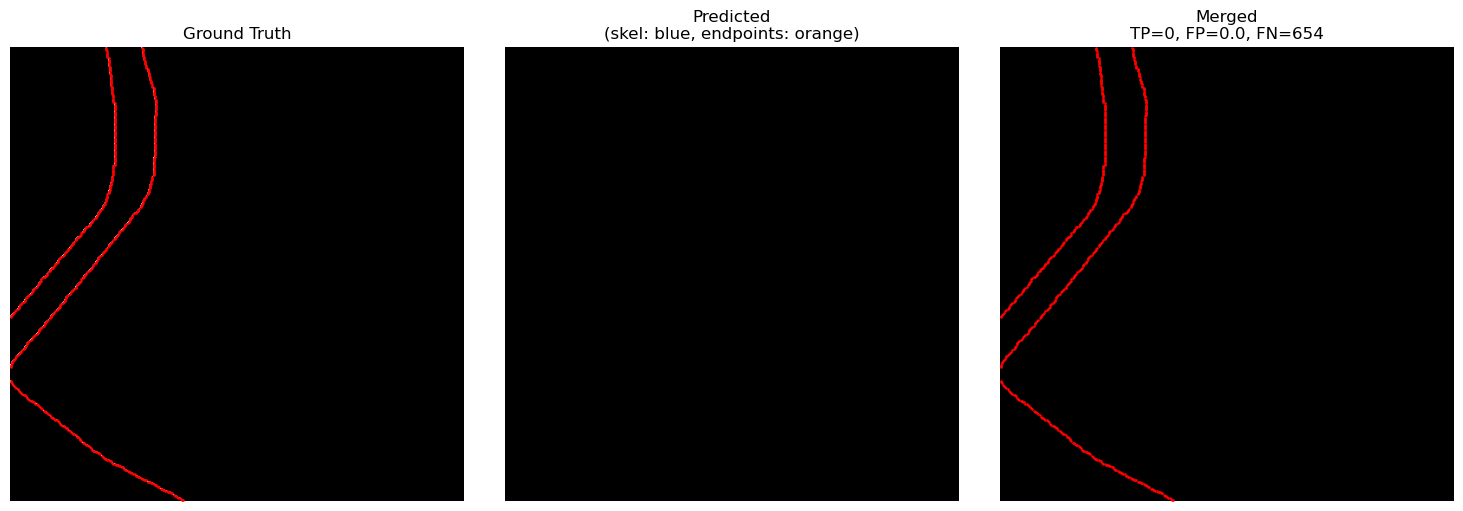

In [ ]:
# Visualize predictions
i = 0
pred_mask, target_mask = get_pred_mask(all_preds, all_targets, i)

plot_skeletons(pred_mask, d=1, d_merge=1, gt_mask=target_mask)